# Projeto Previsão de Ações 

## Análise de Séries Temporais - Parte I

Neste projeto será apresentado todo o conjunto de testes estatísticos para o diagnóstico em séries temporais, bem como serão implementadas funções para faciliar o diagnóstico em conjunto de dados.

Todo o projeto foi densenvolvido como benchmark para futuros projetos. Este é um projeto com a resolução de um problema real, só serão apresentados detalhes técnicos, os nomes foram substituídos por "XXXX".

In [2]:
#libs
import pandas as pd
import numpy as np

from pymongo import MongoClient
from datetime import datetime
from scipy import stats

import statsmodels.graphics.tsaplots as smt
import statsmodels.graphics.gofplots as sm
import statsmodels.sandbox.stats.runs as wald
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
%matplotlib inline

/home/wesley/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Banco de Dados

Gerar um data set a partir do número de processos por dia. Ou seja, uma série temporal da entrada de processos que ocorrem no intervalo de um dia.

A base de dados foi gerada a partir do banco de dados da extração de processos da empresa "XXXX" base cível, com número de processos diários a partir do ano de 2010 até o ano de 2018. 

In [3]:
settings_mong = {
    'host':'localhost',
    'port':******,
    'db':'tribunais_extracao',
    'collection':'extracao_xxxxxx'
}

In [4]:
client = MongoClient(settings_mong['host'], settings_mong['port'])
db = client[settings_mong['db']]
collection = db[settings_mong['collection']]

In [5]:
df = pd.DataFrame(list(collection.find({},{'data_distribuicao':1})))

In [6]:
df.dropna(inplace=True)
df.drop([160218], inplace=True)

In [7]:
df['year'] = df.data_distribuicao.apply(lambda row: row.split()[0])
df['year'] = df.year.apply(lambda row: row.split("/")[2])

In [8]:
df['month'] = df.data_distribuicao.apply(lambda row: row.split("/")[1])
df['month'] = df.month.apply(lambda row: row.zfill(2))

In [9]:
df1 = df.groupby(['year', 'month']).size().reset_index(name='count')

In [10]:
df1['data'] = df1[['year', 'month']].apply(lambda row: '-'.join(row), axis=1)

In [11]:
df1['data'] = df1.data.apply(lambda row: pd.Timestamp(row).to_pydatetime())

In [12]:
df2 = df1[['data', 'count']]

In [13]:
df2 = df1.sort_values(['data'])

In [14]:
df3 = df2[['data', 'count']][31:127]
df3.set_index('data', inplace=True)

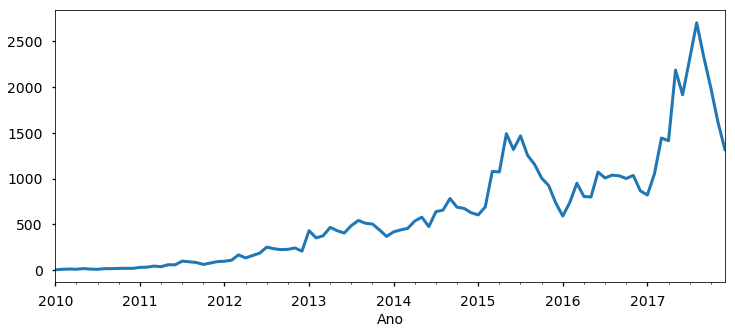

In [15]:
df3['count'].plot(figsize=(12,5), linewidth=3, fontsize=14)
plt.xlabel('Ano', fontsize=14);

## Stationarity, Trends and Seasonality

### Stationarity

Para que um processo estocástico seja estacionário sua média e variância devem ser constantes ao longo do tempo e o valor de sua covariância entre os dois períodos de tempo depender apenas da distância, do intervalo ou da defasagem entre os dois períodos e não do tempo real. Se uma série temporal é não estacionária só podemos estudar seu compartamento no período de tempo em questão não sendo possível generalizar os resultados para outros períodos.

<div style="text-align:center">
$E[Y_t] = \mu $
</div>


<div style="text-align:center">
$Var[Y_t] = E(Y_t - \mu)^2 = \sigma^2$
</div>

<div style="text-align:center">
$\gamma_k = E[(Y_t - \mu)(Y_{t+k} - \mu)]$
</div>

Para verificar se uma série é estacionária ou não estacionária, podemos recorrer a análises gráficas e testes de correlação, correlograma e um teste bastante conhecido é o teste de Dickey-Fuller (ADF). Em seguida demostraremos como realizar estas análises de diferentes formas, bem como criaremos funções para automatizar os principais testes para uso futuro.


#### Autocorrelation

O gráfico de correlação ou autorcorrelção de uma série estacionária deve ser semelhante ao gráfico de correlçao de um ruído branco, ou seja, a autocorrelação gira em torno de zero em várias defasagens. Se o coeficiente de autocorrelação começa em valores elevados e diminui de forma lenta, tal série serà não estacionária. Em seguida mostraemos o gráfico de autocorrelção e autocorrelação parcial. 

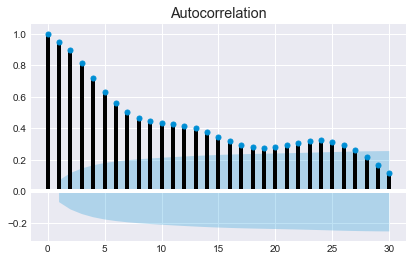

In [40]:
#autocorrelation function
smt.plot_acf(pd.Series(df3['count']), lags=30, alpha=0.5);

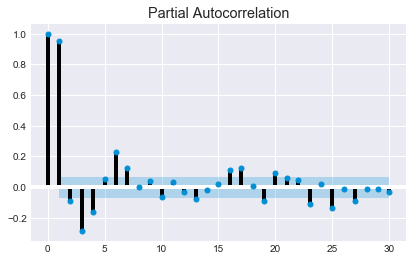

In [41]:
#partial autocorrelation function
smt.plot_pacf(pd.Series(df3['count']), lags=30, alpha=0.5);

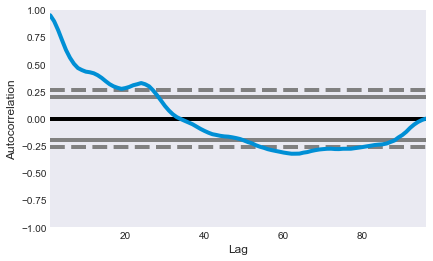

In [42]:
pd.plotting.autocorrelation_plot(df3['count']);

#### Augmented Dickey-Fuller Test (ADF)

Esse teste é uma versão mais poderosa do teste de Dickey-Fuller (DF), no teste DF consideramos que $\epsilon_t$ (termo de ruído branco) é não correlacionado, já o teste (ADF) não precissa desse pressuposto. Esse teste foi desenvolvido para verificar se um modelo autorregressivo tem ou não raiz unitária. 

As hipóteses do teste são:

$Hipótese \;nula\; H_0$: $\; \delta = 0 $ (existe uma raiz unitária ou a série temporal é não estacionária, ou ela possui uma tendência estocástica)

$Hipótese \;alternativa\; H_1$: $\; \delta < 0 $ (a série temporal é estacionária, provavelmente em torno de uma tendência determinística)


Pela função adfuller em python obtemos o resultado da estatística do teste e o p-valor, para rejeitarmos a hipótese nula o valor da estatística do teste deve ser menor que os valores críticos, ou seja, a estatística do teste dever ser mais negativa do que os valores criticos a um nível $\alpha$ de significância. 

In [19]:
print('Results of Augmented Dickey-Fuller test:')
df_test = adfuller(pd.Series(df3['count']), autolag='AIC')
df_output = pd.Series(df_test[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])

for key, value in df_test[4].items():
    df_output['Critical Value (%s)'%key] = value
print(df_output)

Results of Augmented Dickey-Fuller test:
test statistic           0.269176
p-value                  0.975885
# of lags                7.000000
# of observations       88.000000
Critical Value (1%)     -3.506944
Critical Value (5%)     -2.894990
Critical Value (10%)    -2.584615
dtype: float64


### Transformações

Existe duas razões principais para se transformar os dados originais, estabilizar a variância e tornar o efeito sazonal aditivo. Entretanto, é necessário destacar que transformações não melhoram a qualidade da previsão e a previsão dos antilogaritmos, no caso de transformação logarítmica, são estimadores viesados e no caso devem ser ajustados. Uma solução para isso foi proposta por Meyer. 

Para algumas séries temporais pode ser necessário uma transformação não linear, como a logarítmica ou uma tranformação (*Transformação de Box-Cox*) da forma:

<div style="text-align:center">
\begin{equation*}
Z^{(\lambda)}_t = \begin{cases} \frac{Z^{\lambda}_t-1}{\lambda}, & \mbox{se } \lambda \neq 0, \\ log Z_t, & \mbox{se } \lambda = 0, \end{cases}
\end{equation*}
</div>

Uma metodologia intuitiva de qual a transformação ideal para os dados pode ser obtida por uma análise gráfica que traz no eixo das abcissas médias de *k* subconjuntos de observações da série original e no eixo das ordenadas a amplitude ou o desvio padrão de cada um desses  *k* subconjuntos. Fazendo esse gráfico de dispersão Jenkins sugere algumas transformações adequadas.

Outra razão para se realizar transformações na nossa série temporal é para obter uma distribuição para os dados mais simétrica e próxima da normal.

Pela análise gráfica já podemos visualizar o melhor valor de $\lambda$, porém esse método não é exato, podemos chegar mais próximo do lambda correto utilizando a metodologia de Hinkley, a qual sugere que seja calculado a média, mediana e desvio padrão, e então, para a transformação $Z^{\lambda}_t$ e $\lambda$ tomando valores $-3, -2, -1, -1/2, -1/4, 0, 1/4, 1/2, 1, 2, 3$, escolhe-se o valor de $\lambda$ que minimize

<div style="text-align:center">
$d_{\lambda} = \frac{|média - mediana|}{desvio \; padrão}$.
</div>

Na tabela a seguir é dado as tranformações adequadas para o valores de lambda respesctivos, sendo q o menor valor de $d_{\lambda i}$ deve ser escolhido.

|$\lambda$|$d_{\lambda i}$|Transformação|
|---|---|---|
|-1.0|$d_{\lambda1}$|$1/Z_t$|
|-0.5|$d_{\lambda2}$|$1/Z_t^{1/2}$|
|0|$d_{\lambda3}$|$log(Z_t)$|
|0.5|$d_{\lambda4}$|$Z_t^{1/2}$|
|1.0|$d_{\lambda5}$|$Z_t$|


<img src="boxcox.png", width=600, heigth=600, title="Valores de lambda e suas respectivas transformações."/>

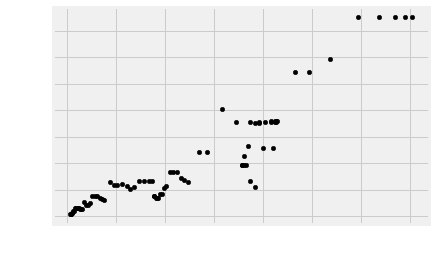

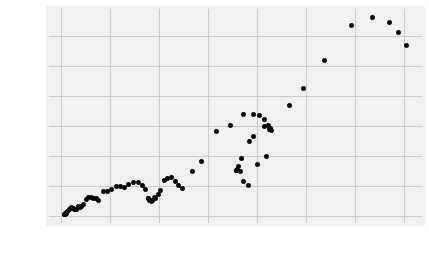

In [22]:
#plot amplitude/std x mean
m_z = df3['count'].rolling(12, center=True).mean()
s_z = df3['count'].rolling(12, center=True).std()
mx_z = df3['count'].rolling(12, center=True).max()
mm_z = df3['count'].rolling(12, center=True).min()
w_z = mx_z-mm_z

df_graph = pd.DataFrame({'mz':m_z,'stdz':s_z,'wz':w_z})
df_graph.dropna(inplace=True)

df_graph.plot.scatter(x='mz', y='wz', color='black');
plt.xlabel('Média', fontsize=12);
plt.ylabel('Amplitude', fontsize=12);
df_graph.plot.scatter(x='mz', y='stdz', color='black');
plt.xlabel('Média', fontsize=12);
plt.ylabel('Desvio Padrão', fontsize=12);

In [23]:
#metodology of Hinkley

x = [((x**(-1)-1)/-1) for x in df_graph.mz]
dy = np.abs(np.mean(x)-np.median(x))/np.std(x)
x1 = [((x**(-0.5)-1)/-0.5) for x in df_graph.mz]
dy1 = np.abs(np.mean(x1)-np.median(x1))/np.std(x1)
x2 = [np.log(x) for x in df_graph.mz]
dy2 = np.abs(np.mean(x2)-np.median(x2))/np.std(x2)
x3 = [((x**(0.5)-1)/0.5) for x in df_graph.mz]
dy3 = np.abs(np.mean(x3)-np.median(x3))/np.std(x3)
x4 = [((x**(1)-1)/1) for x in df_graph.mz]
dy4 = np.abs(np.mean(x4)-np.median(x4))/np.std(x4)
print("lambda: test\t", 'lambda:values')
print("lambda: -1\t", dy)
print("lambda: -0.5\t", dy1)
print("lambda:  0\t", dy2)
print("lambda:  0.5\t", dy3)
print("lambda:  1\t", dy4)


lambda: -1	 0.41700665137
lambda: -0.5	 0.414346456562
lambda:  0	 0.27210529783
lambda:  0.5	 0.0153754488068
lambda:  1	 0.226539389118


In [27]:
#test of Box-Cox
serie_zt, lambd = stats.boxcox(df3['count'])
print('Valor ótimo de lambda: ', lambd)

Valor ótimo de lambda:  0.313460930366


Diante destes testes descobrimos que nossa série precisa de uma transformação do tipo $Z_t^{1/2}$. A metodologia proposta por Hinkley aproxima bem o valor ótimo de $\lambda$.

### Trend

Um modelo de série temporal pode ser decomposto em três componentes tendência, sazonalidade e uma componente aleatória:

<div style="text-align:center">
$Z_t = T_t + S_t + \epsilon_t$
</div>

em que: $Z_t$ é a série temporal, $T_t$ é a tendência, $S_t$ é a sazonalidade e $\epsilon_t$ é a componente aleatória.

A tendência de uma série temporal é definida como um padrão de crescimento ou decrescimento da variável em um período de tempo $t$. Se desconsiderarmos a sazonalidade então teremos:

<div style="text-align:center">
$Z_t = T_t + \epsilon_t$
</div>

Dessa forma, cabe entendermos o comportamento desta tendência. Existe diferentes métodos para estimar $T_t$, os mais utilizados são:

1. ajustar uma função do tempo, polinômio ou exponencial;
2. suavizar ou filtrar os valores da série em torno de um ponto, para estimar a tendência naquele ponto;
3. suavizar os valores da série por meio de sucessivos ajustes de retas de mínimos quadrados ponderados.

Estimada a tendência obtemos a série livre de tendência por meio de:

<div style="text-align:center">
$Y_t = Z_t - \hat{T_t}$
</div>

Ou podemos tomar sucessivas diferenças dos valores da série,

<div style="text-align:center">
$\Delta Z_t = Z_t - Z_{t-1}$
</div>


Vamos observar a tendência da série estudada usando médias móveis sobre uma janela específica observações passadas. Essa metodologia também pode ser utilizada com a mediana e o desvio padrão dos valores da série.


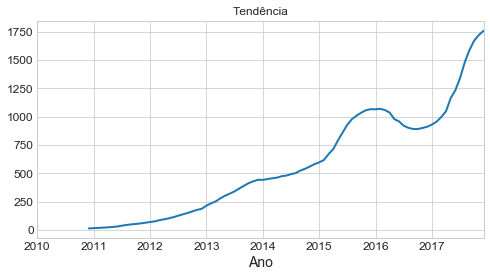

In [23]:
df3.rolling(window=12).mean().plot(figsize=(8,4), linewidth=2, fontsize=12, legend=None, title='Tendência')
plt.xlabel('Ano', fontsize=14);

Agora vamos montar um gráfico mais complexo, em que podemos estudar a série original a tendência pela médias móveis e pelo desvio padrão.

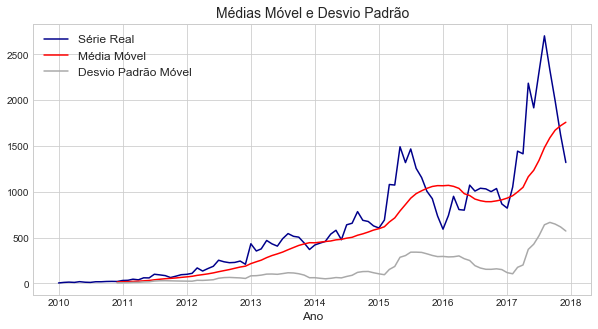

In [55]:
#moving averages
rolling_mean = pd.Series(df3['count']).rolling(window=12, center=False).mean()
rolling_std = pd.Series(df3['count']).rolling(window=12, center=False).std()

#plot
plt.figure(figsize=(10,5))
plt.plot(pd.Series(df3['count']), color='darkblue', label='Série Real')
plt.plot(rolling_mean, color='red', label='Média Móvel')
plt.plot(rolling_std, color='darkgray', label='Desvio Padrão Móvel')
plt.legend(loc='best', fontsize=12)
plt.title('Médias Móvel e Desvio Padrão', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.show()

Graficamente podemos identificar que existe uma tência na série, ou seja, o número de ações judiciais tem crescido todo ano.
 

### Seasonality 

A sazonalidade está ligada as variações que a série sofre períodicamente (semanal, mensal, etc.). Vamos verificar se nossa série possui sazonalidade plotando um gráfico da nossa série por ano e mês.  

['Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' 'Nov' 'Dec']


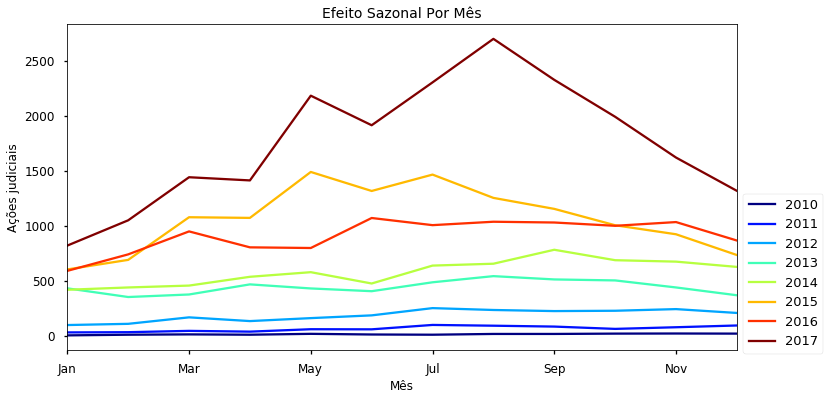

In [16]:
#seasonality
df4 = df3
df4['Month'] = df4.index.strftime("%b")
df4['Year'] = df4.index.year

month_names = pd.date_range(start='2010-01-01', periods=12, freq='MS').strftime('%b')

df_piv = df4.pivot(index='Month', columns='Year', values='count')
df_piv = df_piv.reindex(index=month_names)

#plot
df_piv.plot(colormap='jet', figsize=(12,6), fontsize=12)
plt.title('Efeito Sazonal Por Mês', fontsize=14)
plt.ylabel('Ações judiciais', fontsize=12)
plt.xlabel('Mês', fontsize=12)
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

Para formalizar melhor o que descrevemos no gráfico anterior podemos utilizar uma abordagem mais fomal com o gráfico box plot o qual indicará a distribuição da série estudada por mês. 

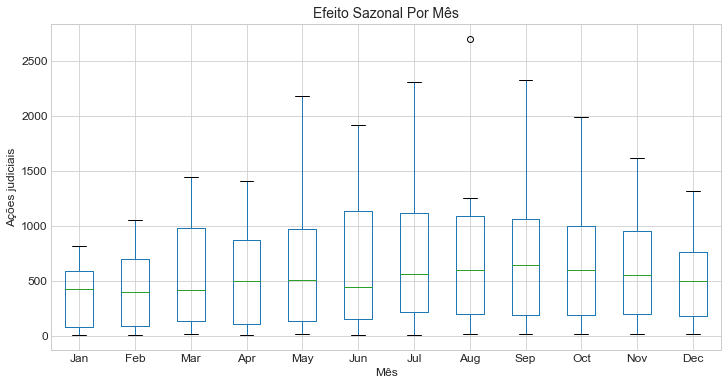

In [129]:
#new pivot table
df_piv_box = df4.pivot(index='Year', columns='Month', values='count')
#reindex columns
df_piv_box = df_piv_box.reindex(columns=month_names)
#box plot
df_piv_box.plot(kind='box', fontsize=12, figsize=(12,6))
plt.title('Efeito Sazonal Por Mês', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Ações judiciais', fontsize=12)
plt.show()

Com este gráfico podemos ver que os meses de julho, agosto, setembro, outubro e novembro apresentão os maiores picos de ações judiciais, pois possuem as maiores médias. Para estes meses a variância é muito alta. Também é prossível destacar que o número de ações após o mês de setembro se torna decrescente até o mês de março. Desta forma, podemos destacar um efeito sazonal ciclo de 12 meses. 

### Time Serie Decomposition

Como já descrevemos uma série temporal é composta por três componentes: tendência (ciclo) $T_t$, sazonalidade $S_t$ e um componente aleatório $\epsilon_t$. Se considerarmos um modelo aditivo temos:

<div style="text-align:center">
$Y_t = T_t + S_t + \epsilon_t$
</div>

Considerando um modelo multiplicativo temos:

<div style="text-align:center">
$Y_t = T_t \cdot S_t \cdot \epsilon_t$
</div>

A questão aqui é escolher qual o modelo que descreve a nossa série?
O modelo aditivo é mais apropriado se a magnitude das flutuações sazonais ou a variação em torno do ciclo de tendência não variarem com o nível da série temporal. Quando a variação no padrão sazonal, ou a variação em torno do ciclo de tendência, parece ser proporcional ao nível da série temporal, então um modelo multiplicativo é mais apropriado. Se utilizarmos o modelo aditivo e os valores do resíduo forem alto, isso indica que um modelo multiplicativo é mais indicado. Neste caso, vamos fazer a decomposição da nossa série com o modelo multiplicativo.

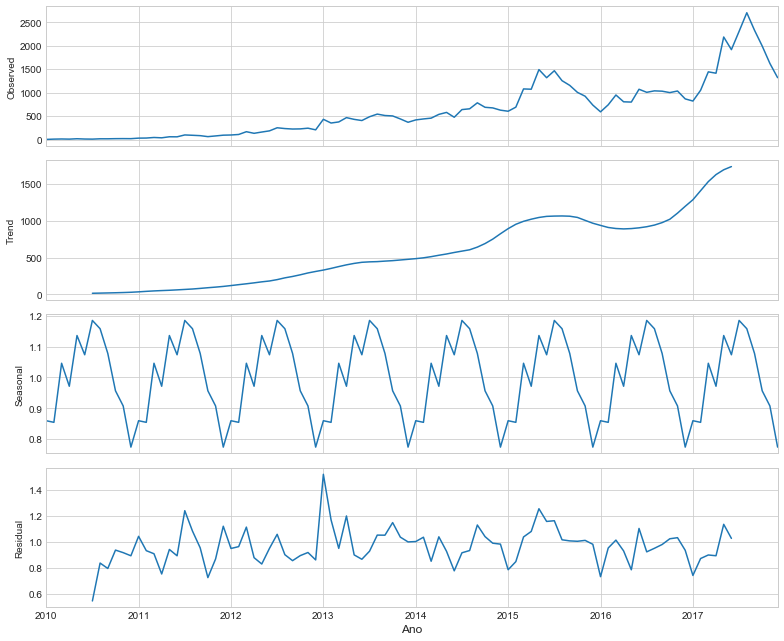

In [262]:
#decompose
decomp = seasonal_decompose(pd.Series(df3['count']), model='multiplicative')
plt.figure(figsize=(12,6))
decomp.plot()
plt.xlabel('Ano', fontsize=12)
plt.show()

### Time Serie Diagnostics

Para automatizar o diagnóstico em trabalhos futuros vamos criar uma função chamada **ts_fearure**, em que será implementado o teste ADF, os gráficos da autocorrelação e autocorrelação parcial, histograma e QQ plot. 

In [23]:
#A function to diagnostics in time series

def ts_feature(serie, lags=None, title="", filename=""):
    """
    Funcao para diagnotico em series temporais, analise grafica - autocorrelacao, autocorrelacao parcial, qq plot,
    histograma e teste de Dickey Fuller aumentado-ADF
    """
      
    if isinstance(serie, pd.Series):
        serie = pd.Series(serie)
    
    #layouts
    fig = plt.figure(figsize=(14, 14))
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    hist_ax = plt.subplot2grid(layout, (2, 0))
    qq_ax = plt.subplot2grid(layout, (2, 1))
   
    
    #time serie graphic
    ax = serie.plot(ax = ts_ax, lw=2, colormap='jet', marker='.', markersize=7, label='Série Real', fontsize=12)
    serie.rolling(window=12, center=False).mean().plot(ax=ts_ax, color='darkred', label='Média Móvel', fontsize=12)
    serie.rolling(window=12, center=False).std().plot(ax=ts_ax, color='darkgray', label='Desvio Padrão Móvel', fontsize=12)
    ax.legend(loc='best')
    ax.set_xlabel("Ano")
    ax.set_ylabel("Número de Ações")
    ts_ax.set_title(title, fontsize = 14)
    
    #autocorrelation and partial autocorrelation graphic
    smt.plot_acf(serie, lags = lags, ax = acf_ax, alpha = 0.5)
    acf_ax.set_title('Autocorrelação', fontsize=14)
    smt.plot_pacf(serie, lags = lags, ax = pacf_ax, alpha = 0.5)
    pacf_ax.set_title('Autocorrelação Parcial', fontsize=14)
    
    
    #histogram graphic
    ax = serie.plot(ax=hist_ax, kind='hist')
    ax.set_ylabel('Frequência')
    hist_ax.set_title('Histograma', fontsize=14)
    
    #qq plot graphic
    sm.qqplot(serie, line='s', ax=qq_ax)
    plt.xlabel('Quantis Teóricos')
    plt.ylabel('Quantis Amostrais')
    qq_ax.set_title("Gráfico Q-Q", fontsize=14)  
    plt.tight_layout()
    plt.show()
        
    
    print('\n\nResults of Augmented Dickey-Fuller test:\n')
    dftest = adfuller(serie, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return

Na função **ts_trendseason** automatizamos o diagnóstico da tendência e da sazonalidade, detalhando ao máximo esses componentes da série, dessa forma podemos tomar decisões mais acertadas sobre a série original.

In [66]:
def ts_trendseason(serie, title=""):
    
    #pivot
    serie_sz = serie
    
    #trend
    serie = pd.Series(serie[serie.columns[0]])
    
    #layouts
    fig = plt.figure(figsize=(14, 18))
    layout = (4, 2)
    tw1_ax = plt.subplot2grid(layout, (0, 0))
    tw2_ax = plt.subplot2grid(layout, (0, 1))
    tw3_ax = plt.subplot2grid(layout, (1, 0))
    tw4_ax = plt.subplot2grid(layout, (1, 1))
    szy_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
    szm_ax = plt.subplot2grid(layout, (3, 0), colspan=2)
    
    
    ##time serie graphic
    #4 month
    ax = serie.plot(ax = tw1_ax, lw=2, colormap='jet', marker='.', markersize=7, label='Série Real', fontsize=12)
    serie.rolling(window=4, center=False).mean().plot(ax=tw1_ax, color='darkred', label='4 Meses - Média Móvel', fontsize=12)
    serie.rolling(window=4, center=False).std().plot(ax=tw1_ax, color='darkgray', label='4 Meses - Desvio Padrão Móvel', fontsize=12)
    ax.legend(loc='best')
    ax.set_xlabel("Ano")
    ax.set_ylabel("Número de Ações")
    plt.title(title, fontsize = 14)
    #6 month
    ax = serie.plot(ax = tw2_ax, lw=2, colormap='jet', marker='.', markersize=7, label='Série Real', fontsize=12)
    serie.rolling(window=6, center=False).mean().plot(ax=tw2_ax, color='darkred', label='6 Meses - Média Móvel', fontsize=12)
    serie.rolling(window=6, center=False).std().plot(ax=tw2_ax, color='darkgray', label='6 Meses - Desvio Padrão Móvel', fontsize=12)
    ax.legend(loc='best')
    ax.set_xlabel("Ano")
    ax.set_ylabel("Número de Ações")
    #8 month
    ax = serie.plot(ax = tw3_ax, lw=2, colormap='jet', marker='.', markersize=7, label='Série Real', fontsize=12)
    serie.rolling(window=8, center=False).mean().plot(ax=tw3_ax, color='darkred', label='8 Meses - Média Móvel', fontsize=12)
    serie.rolling(window=8, center=False).std().plot(ax=tw3_ax, color='darkgray', label='8 Meses - Desvio Padrão Móvel', fontsize=12)
    ax.legend(loc='best')
    ax.set_xlabel("Ano")
    ax.set_ylabel("Número de Ações")
    #12 month
    ax = serie.plot(ax = tw4_ax, lw=2, colormap='jet', marker='.', markersize=7, label='Série Real', fontsize=12)
    serie.rolling(window=12, center=False).mean().plot(ax=tw4_ax, color='darkred', label='12 Meses - Média Móvel', fontsize=12)
    serie.rolling(window=12, center=False).std().plot(ax=tw4_ax, color='darkgray', label='12 Meses - Desvio Padrão Móvel', fontsize=12)
    ax.legend(loc='best')
    ax.set_xlabel("Ano")
    ax.set_ylabel("Número de Ações")
  
    #seasonality 
    serie_sz['Month'] = serie_sz.index.strftime("%b")
    serie_sz['Year'] = serie_sz.index.year
    month_names = pd.date_range(start=serie_sz.index[0], periods=12, freq='MS').strftime('%b')

    #scater plot
    df_piv = serie_sz.pivot(index='Month', columns='Year', values=serie_sz.columns[0])
    df_piv = df_piv.reindex(index=month_names)
    
    df_piv.plot(ax=szy_ax,colormap='jet', fontsize=12)
    szy_ax.set_title('Efeito Sazonal Por Mês', fontsize=14)
    szy_ax.set_ylabel('Ações judiciais', fontsize=12)
    szy_ax.set_xlabel('Mês', fontsize=12)
    szy_ax.legend(loc='best', bbox_to_anchor=(1.0, 0.7))
    
    #box plot
    #new pivot table
    df_piv_box = serie_sz.pivot(index='Year', columns='Month', values=serie_sz.columns[0])
    #reindex columns
    df_piv_box = df_piv_box.reindex(columns=month_names)
    #box plot
    df_piv_box.plot(ax=szm_ax, kind='box', fontsize=12)
    szm_ax.set_title('Efeito Sazonal Por Mês', fontsize=14)
    szm_ax.set_xlabel('Mês', fontsize=12)
    szm_ax.set_ylabel('Ações judiciais', fontsize=12)   
    
    return
    

In [60]:
##data transformation

def data_transformation(serie):
    
    #layouts
    fig = plt.figure(figsize=(14, 18))
    layout = (4, 2)
    amp_ax = plt.subplot2grid(layout, (0, 0))
    std_ax = plt.subplot2grid(layout, (0, 1))
    
    m_z = serie.rolling(12, center=True).mean()
    s_z = serie.rolling(12, center=True).std()
    mx_z = serie.rolling(12, center=True).max()
    mm_z = serie.rolling(12, center=True).min()
    w_z = mx_z-mm_z

    df_graph = pd.DataFrame({'mz':m_z,'stdz':s_z,'wz':w_z})
    df_graph.dropna(inplace=True)
    
    #plot
    df_graph.plot.scatter(ax=amp_ax, x='mz', y='wz', color='black');
    amp_ax.set_xlabel('Média', fontsize=12);
    amp_ax.set_ylabel('Amplitude', fontsize=12);
    df_graph.plot.scatter(ax=std_ax, x='mz', y='stdz', color='black');
    std_ax.set_xlabel('Média', fontsize=12);
    std_ax.set_ylabel('Desvio Padrão', fontsize=12);
    plt.show()
    
    #table
    #metodology of Hinkley
    x = [((x**(-1)-1)/-1) for x in df_graph.mz]
    dy = np.abs(np.mean(x)-np.median(x))/np.std(x)
    x1 = [((x**(-0.5)-1)/-0.5) for x in df_graph.mz]
    dy1 = np.abs(np.mean(x1)-np.median(x1))/np.std(x1)
    x2 = [np.log(x) for x in df_graph.mz]
    dy2 = np.abs(np.mean(x2)-np.median(x2))/np.std(x2)
    x3 = [((x**(0.5)-1)/0.5) for x in df_graph.mz]
    dy3 = np.abs(np.mean(x3)-np.median(x3))/np.std(x3)
    x4 = [((x**(1)-1)/1) for x in df_graph.mz]
    dy4 = np.abs(np.mean(x4)-np.median(x4))/np.std(x4)
    
    print("Metodologia proposta por Hinkley para tranformação da série:")
    print("   OBS: O valor que minimiza lambda deve ser escolhido!\n")
    print("lambda: test\t", 'lambda:values\t', 'Transformação adequada')
    print("lambda: -1\t", dy,'\t\t 1/Z')
    print("lambda: -0.5\t", dy1,'\t 1/Z^1/2')
    print("lambda:  0\t", dy2,'\t\t log(Z)')
    print("lambda:  0.5\t", dy3,'\t Z^1/2')
    print("lambda:  1\t", dy4,'\t Z')

    print("\n\tValor ótimo de lambda!\n")
    serie_zt, lambd = stats.boxcox(serie)
    print('Valor de Lambda: ', lambd)
    
    return

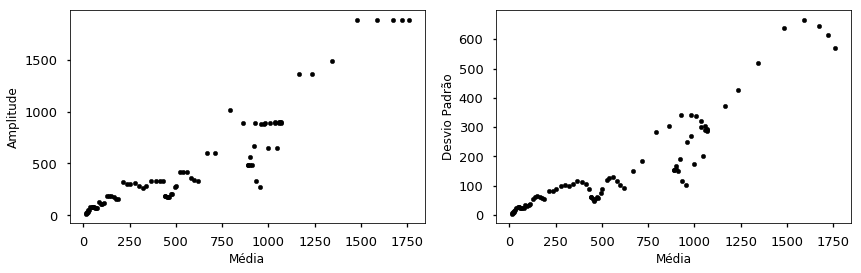

Metodologia proposta por Hinkley para tranformação da série:
   OBS: O valor que minimiza lambda deve ser escolhido!

lambda: test	 lambda:values	 Transformação adequada
lambda: -1	 0.41700665137 		 1/Z
lambda: -0.5	 0.414346456562 	 1/Z^1/2
lambda:  0	 0.27210529783 		 log(Z)
lambda:  0.5	 0.0153754488068 	 Z^1/2
lambda:  1	 0.226539389118 	 Z

	Valor ótimo de lambda!

Valor de Lambda:  0.313460930366


In [61]:
data_transformation(df3['count'])

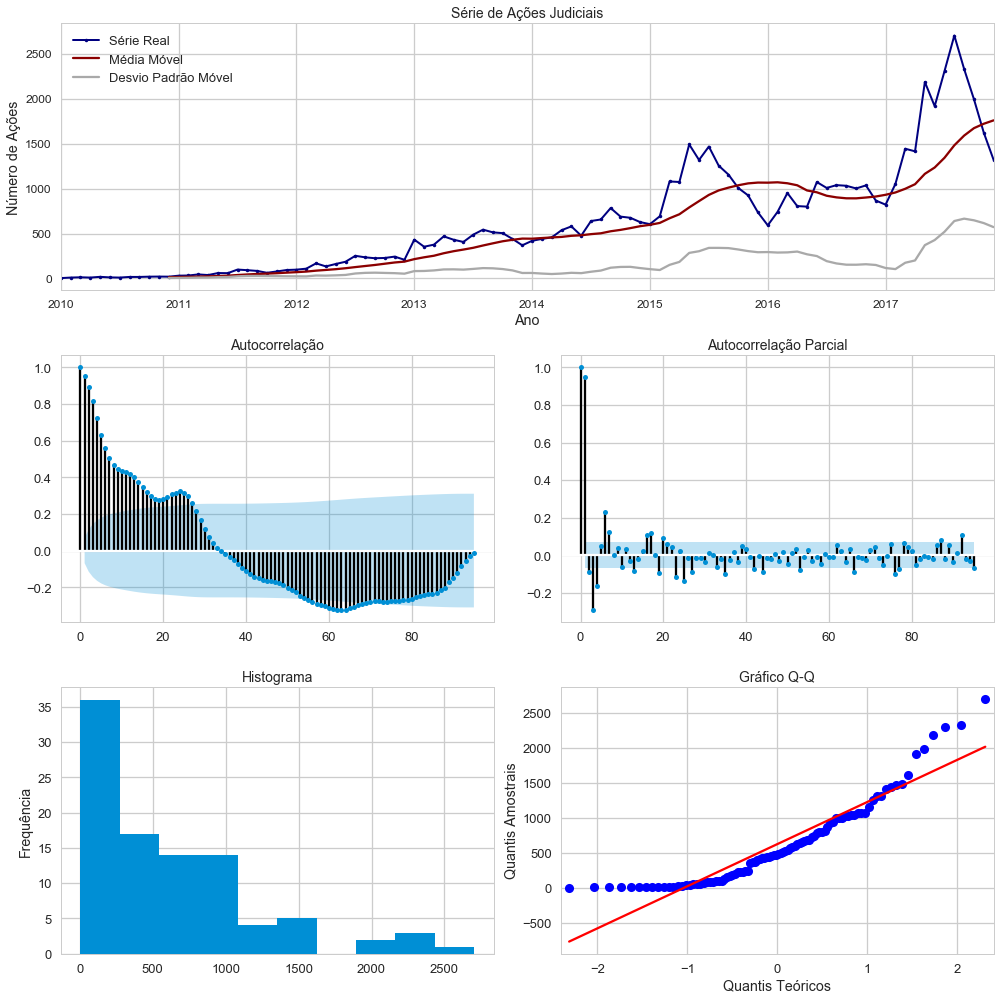



Results of Augmented Dickey-Fuller test:

test statistic           0.269176
p-value                  0.975885
# of lags                7.000000
# of observations       88.000000
Critical Value (1%)     -3.506944
Critical Value (5%)     -2.894990
Critical Value (10%)    -2.584615
dtype: float64


In [71]:
#Applied the ts_test function in our time serie
ts_feature(df3['count'], title='Série de Ações Judiciais')

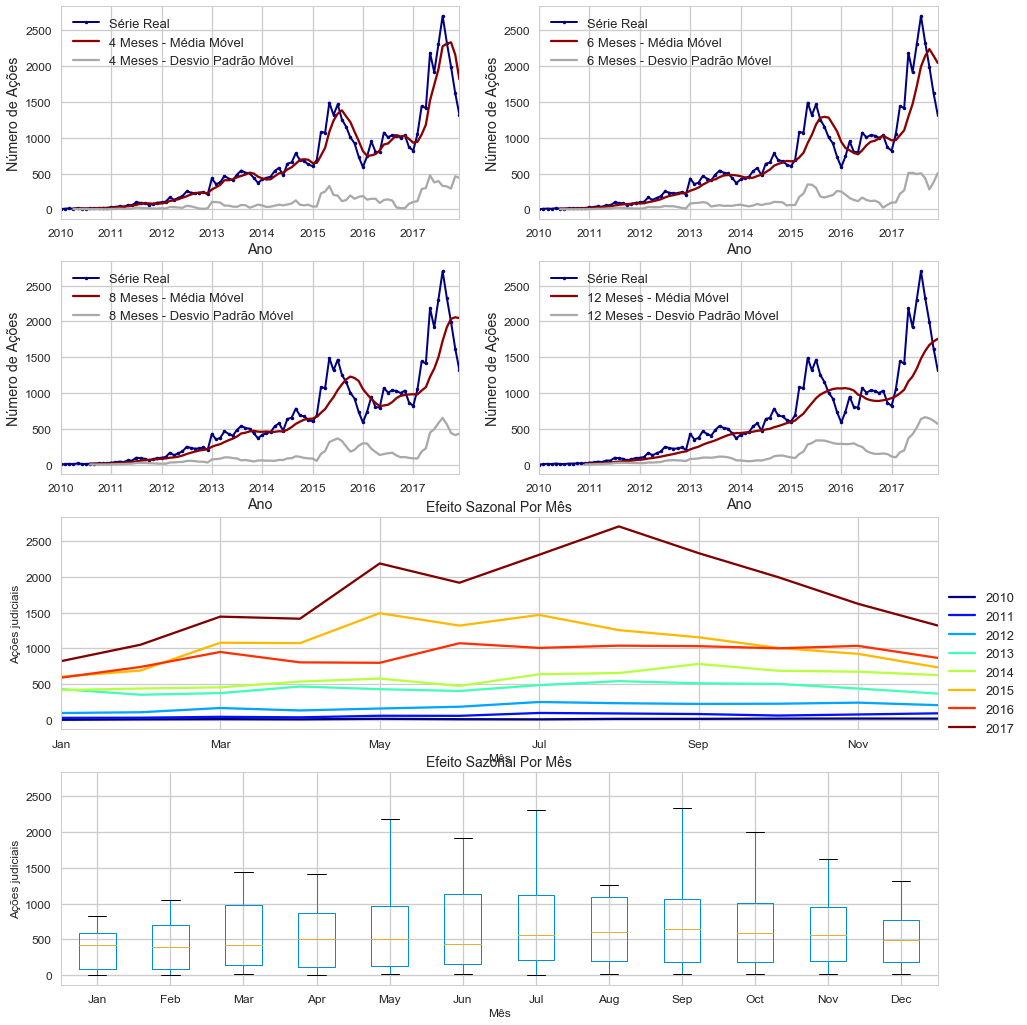

In [70]:
ts_trendseason(df3)

### Stationarize a Time Series

Como foi discutido anteriormente uma série temporal pode se tornar estacionária por meio sucessivas diferenças. Um processo estocástico é chamado de estacionário em diferenças se a aplicação de **d** passos de diferenças é nescessário para tornar o processo estacionário. Dessa forma, o processo é chamado de estacionário de ordem **d**. Para que possamos considerar a série estacionária devemos verificar variações na média e no desvio padrão, bem como vamos verificar pelo teste de Dickey-Fuller. Se o processo não for estacionário em primeira ordem podemos tomar a **d** diferenças, logaritmizar a série ou combinar os métodos. Em seguida vamos tomar a primeira diferença da série e posteriomente testar se a mesma é estacionária com a função *ts_feature*.   

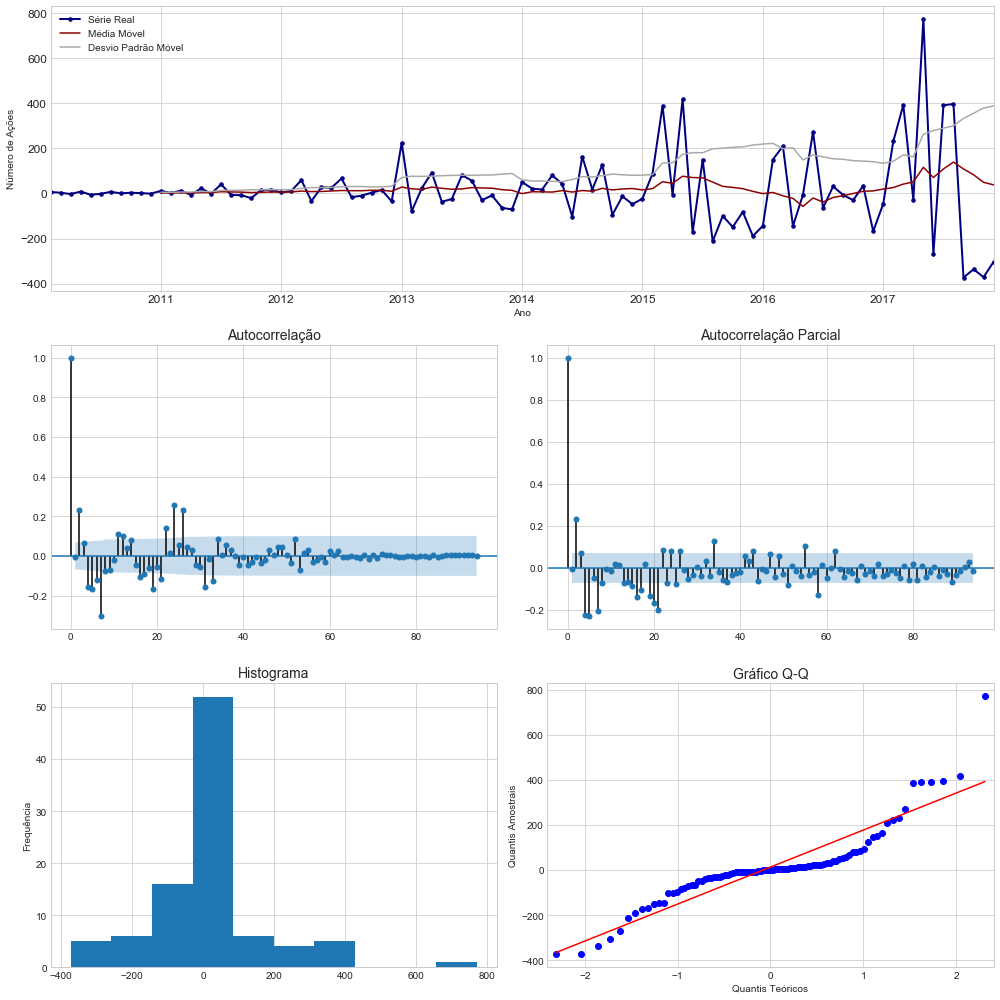



Results of Augmented Dickey-Fuller test:

test statistic         -5.760499e+00
p-value                 5.687151e-07
# of lags               6.000000e+00
# of observations       8.800000e+01
Critical Value (1%)    -3.506944e+00
Critical Value (5%)    -2.894990e+00
Critical Value (10%)   -2.584615e+00
dtype: float64


In [272]:
#first difference
z_diff = pd.Series(df3['count']).diff()
ts_feature(z_diff.dropna())

Graficamente podemos ver que a série se torna estacionária em média, em variância existe uma pequena tendência, porém ela é não significativa como podemos notar pelo teste de aumentado de Dickey-Fuller ao nível de 5% de probabilidade.